<a href="https://colab.research.google.com/github/deshm084/Fashion-MNIST-Generator-GAN-/blob/main/Fashion-MNIST%20Generator%20(GAN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch torchvision matplotlib

100%|██████████| 26.4M/26.4M [00:01<00:00, 16.7MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 311kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 5.62MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 16.3MB/s]


Starting Training... (This takes about 5-10 minutes)
Epoch [1/20] Loss D: 0.8972, Loss G: 1.9845
Epoch [2/20] Loss D: 0.8036, Loss G: 2.6832
Epoch [3/20] Loss D: 0.8189, Loss G: 1.8342
Epoch [4/20] Loss D: 1.1181, Loss G: 1.2064
Epoch [5/20] Loss D: 1.0172, Loss G: 1.5709
Epoch [6/20] Loss D: 1.0045, Loss G: 1.9836
Epoch [7/20] Loss D: 1.2578, Loss G: 1.2121
Epoch [8/20] Loss D: 1.1556, Loss G: 1.4657
Epoch [9/20] Loss D: 1.3112, Loss G: 1.7277
Epoch [10/20] Loss D: 1.1268, Loss G: 1.0766
Epoch [11/20] Loss D: 1.2786, Loss G: 0.9098
Epoch [12/20] Loss D: 1.1411, Loss G: 1.4477
Epoch [13/20] Loss D: 1.1881, Loss G: 0.8754
Epoch [14/20] Loss D: 1.2457, Loss G: 1.0522
Epoch [15/20] Loss D: 1.2514, Loss G: 1.2092
Epoch [16/20] Loss D: 1.1462, Loss G: 1.3338
Epoch [17/20] Loss D: 1.1886, Loss G: 0.8787
Epoch [18/20] Loss D: 1.2022, Loss G: 1.0360
Epoch [19/20] Loss D: 1.2308, Loss G: 1.0011
Epoch [20/20] Loss D: 1.2884, Loss G: 0.9440

Generating Images...


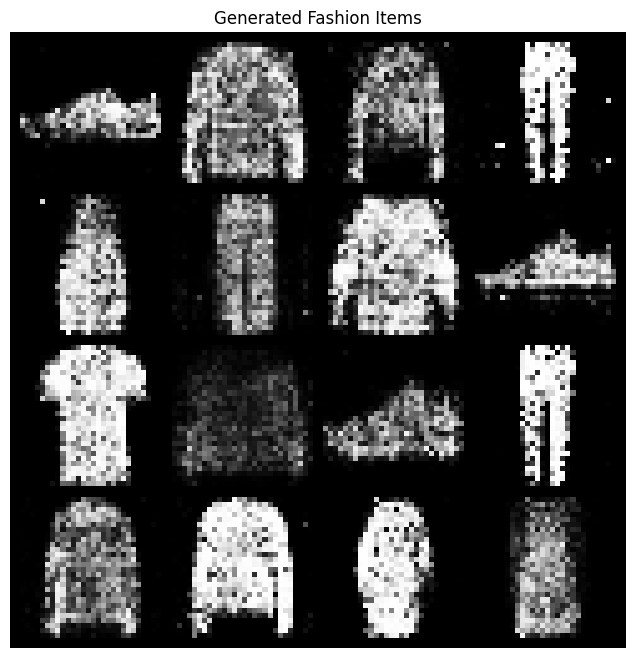

In [ ]:
"""
Project: Fashion-MNIST DCGAN
Author: Sanskruti
Description: A Generative Adversarial Network that learns to generate images of clothing
             from random noise.
"""

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Configuration ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 128
NOISE_DIM = 100 # Size of the random input vector (Latent Space)
LR = 0.0002
BETA1 = 0.5     # Hyperparameter for Adam optimizer (standard for GANs)

# --- 2. Data Loading (Fashion-MNIST) ---
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)) # Normalize to range [-1, 1]
])

dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# --- 3. The Generator (The Artist) ---
# Input: Random Noise (100) -> Output: Image (1x28x28)
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            # Input: N x 100
            nn.Linear(NOISE_DIM, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 28*28),
            nn.Tanh() # Output needs to be between -1 and 1
        )

    def forward(self, x):
        return self.net(x).view(-1, 1, 28, 28)

# --- 4. The Discriminator (The Critic) ---
# Input: Image (1x28x28) -> Output: Probability (Real or Fake)
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid() # Output probability (0 to 1)
        )

    def forward(self, x):
        return self.net(x)

# --- 5. Initialization ---
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Loss Function and Optimizers
criterion = nn.BCELoss() # Binary Cross Entropy
optimizer_G = optim.Adam(generator.parameters(), lr=LR, betas=(BETA1, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=LR, betas=(BETA1, 0.999))

# --- 6. Training Loop ---
print("Starting Training... (This takes about 5-10 minutes)")

for epoch in range(20): # Train for 20 Epochs
    for i, (real_images, _) in enumerate(dataloader):
        batch_size = real_images.size(0)
        real_images = real_images.to(device)

        # Labels
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # ==========================
        #  TRAIN DISCRIMINATOR
        # ==========================
        optimizer_D.zero_grad()

        # 1. Train on Real Images
        outputs = discriminator(real_images)
        loss_d_real = criterion(outputs, real_labels)

        # 2. Train on Fake Images
        z = torch.randn(batch_size, NOISE_DIM).to(device) # Generate Random Noise
        fake_images = generator(z)
        outputs = discriminator(fake_images.detach()) # Detach so we don't calculate G gradients yet
        loss_d_fake = criterion(outputs, fake_labels)

        # Optimize
        loss_d = loss_d_real + loss_d_fake
        loss_d.backward()
        optimizer_D.step()

        # ==========================
        #  TRAIN GENERATOR
        # ==========================
        optimizer_G.zero_grad()

        # We want the discriminator to think these fakes are REAL
        outputs = discriminator(fake_images)
        loss_g = criterion(outputs, real_labels) # Note: We use REAL labels here! trickery!

        loss_g.backward()
        optimizer_G.step()

    print(f"Epoch [{epoch+1}/20] Loss D: {loss_d.item():.4f}, Loss G: {loss_g.item():.4f}")

# --- 7. Visualization ---
print("\nGenerating Images...")
z = torch.randn(16, NOISE_DIM).to(device)
fake_images = generator(z).cpu().detach()

# Plot
plt.figure(figsize=(8,8))
grid_img = torchvision.utils.make_grid(fake_images, nrow=4, padding=2, normalize=True)
plt.imshow(grid_img.permute(1, 2, 0))
plt.axis('off')
plt.title("Generated Fashion Items")
plt.show()